In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.fftpack
import pickle
from sklearn.preprocessing import RobustScaler
import os.path
from os import path
from tqdm.notebook import tqdm
import scipy.signal as signal

In [2]:
# define constant variables
# SECONDS_PER_EPOCH = 25
ANNOTATION_PATH = '../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline'
RAW_EDF_PATH = '../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline'
SIGNAL_READ_PPG = 'RD-Pleth'
SIGNAL_READ_SPO2 = 'SpO2'
fs = 128
pjoin = os.path.join

# run MountingFiles first
os.listdir(ANNOTATION_PATH)[:5], os.listdir(RAW_EDF_PATH)[:5]

(['heartbeat-baseline-700001-nsrr.xml',
  'heartbeat-baseline-700002-nsrr.xml',
  'heartbeat-baseline-700003-nsrr.xml',
  'heartbeat-baseline-700004-nsrr.xml',
  'heartbeat-baseline-700005-nsrr.xml'],
 ['heartbeat-baseline-700001.edf',
  'heartbeat-baseline-700002.edf',
  'heartbeat-baseline-700003.edf',
  'heartbeat-baseline-700004.edf',
  'heartbeat-baseline-700005.edf'])

In [3]:
def check_fft(raw_signals, fs):
    %matplotlib inline

    # Number of samplepoints
    y = raw_signals
    N = len(y)
    print(N)
    # sample spacing
    T = 1.0 / fs
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
#     ax.set_xlim(-1, 70)
#     ax.set_ylim(0, 0.000002)
    plt.show()

In [4]:
def plot_raw_signals(raw_signals):
    plt.plot(raw_signals)
    plt.xlabel('sampling point')
    plt.show()

In [5]:
def plot_hypnogram(labels):
    from pylab import rcParams
    rcParams['figure.figsize'] = 17, 3

    inverse_ytrue = np.array([4-y for y in labels])
    plt.plot(inverse_ytrue, c='#2874A6', label='True label')
    plt.yticks([0, 1, 2, 3, 4],['REM', 'N3', 'N2', 'N1', 'Wake'])
    plt.xticks(list(range(0, len(inverse_ytrue), 60)), [int(l/2) for l in list(range(0, len(inverse_ytrue), 60))])
    plt.legend()
    plt.xlabel('time (minutes)')
    plt.show()

In [6]:
def MinMaxScaler(data):
    """Min Max normalizer.

    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

# def extract_labels_old(fname):
#     tree = ET.parse(fname)
#     root = tree.getroot()
    
#     pid = fname[-len('-profusion.xml')-6:-len('-profusion.xml')]
    
#     labels = []
#     current_seconds = 0
#     is_start_at_zero = False
#     start_time = 0
#     last_sample_start_time = 0
#     last_sample_start_duration = 0
#     list_d = []
#     list_s = []
#     list_l = []
#     i = 0
#     for cmp in root.iter('CMPStudyConfig'):
#         for se in cmp.find('ScoredEvents'):
#             i+= 1
#             event_type = se.find('Name')
#             label_curr = 0
#             if(event_type.text != None):
#                 event_label = se.find('Name')
#                 start = int(se.find('Start').text.split('.')[0])
#                 duration = int(se.find('Duration').text.split('.')[0])
# #                 print(event_type.text)
#                 if(event_label.text.split('|')[0] == 'Central Apnea'):
#                     label_curr = 1
#                 elif(event_label.text.split('|')[0]  in ['Obstructive Apnea', 'Mixed Apnea']):
#                     label_curr = 2
#                 elif(event_label.text.split('|')[0] in ['Hypopnea', 'Obstructive Hypopnea']):
#                     label_curr = 3
#                 elif(event_label.text.split('|')[0] in ['SpO2 desaturation']):
#                     label_curr = 5
#                 elif(event_label.text.split('|')[0] in ['Unsure', 'SpO2 artifact', 'Periodic Breathing', 'RERA', 'Respiratory artifact']):
#                     label_curr = 4
#                 else:
# #                     print(event_type.text, event_label.text, start.text, duration.text, location.text)
#                     raise(Exception('Found error with ' + event_label.text.split('|')[0] + ' at seconds ' + str(start) + ' ' + event_label.text))
#                 list_d.extend([duration])
#                 list_s.extend([start])
#                 list_l.extend([label_curr])

#     #             nepochs = int(int(duration.text) / SECONDS_PER_EPOCH)
#     #             labels.extend([stage_label] * nepochs)
#                 # print(event_type, stage, start, duration, stage_label, nepochs)

#                 if start == 0:
#                     is_start_at_zero = True
#                 if not is_start_at_zero:
#                     start_time = start

#     #             if start != current_seconds:
#     #                 raise(Exception('Sleep stage is missing (From previous epoch to this epoch) at duration: ' + str(start) + str(current_seconds)))

#                     current_seconds += int(duration)
#                     last_sample_start_time = int(start)
#                     last_sample_start_duration = int(duration)
#     #     print(i, len(list_d), list_d, len(list_s), list_s, len(list_l), list_l) 
#     #     print(list_d)
      
#     total_labelling_time = (last_sample_start_time+last_sample_start_duration) - start_time
# #     assert total_labelling_time / SECONDS_PER_EPOCH == len(labels)
#     labels = np.array(list_l)
#     print(pid, 'Total:', len(labels), 'samples | data length:', last_sample_start_time+last_sample_start_duration, np.unique(labels, return_counts=True) )
# #           [len(labels[labels==c]) for c in range(0, 5)], 'others:', len(labels[labels>4]))

#     return list_l, list_d, list_s, start_time, pid

def extract_labels(fname):
    
    tree = ET.parse(fname)
    root = tree.getroot()

    pid = fname[-len('-nsrr.xml')-6:-len('-nsrr.xml')]

    all_labels = []
    labels = []
    current_seconds = 0
    is_start_at_zero = False
    start_time = 0
    last_sample_start_time = 0
    last_sample_start_duration = 0
    i = 0

    for se in root.find('ScoredEvents').iter('ScoredEvent'):
        i+= 1
        location = se.find('SignalLocation')
        label_curr = 0
        if(location != None):
            event_type = se.find('EventType')
            event_label = se.find('EventConcept')
            start = int(se.find('Start').text.split('.')[0])
            duration = int(se.find('Duration').text.split('.')[0])
            if(location.text == 'Thermistor'):
                if(event_label.text.split('|')[0] == 'Central apnea'):
                    label_curr = 1
                elif(event_label.text.split('|')[0] in ['Obstructive apnea', 'Mixed apnea']):
                    label_curr = 2
                elif(event_label.text.split('|')[0] in ['Hypopnea', 'Obstructive Hypopnea']):
                    label_curr = 3
                elif(event_label.text.split('|')[0] in ['SpO2 desaturation']):
                    label_curr = 5
                elif(event_label.text.split('|')[0] in ['Unsure', 'SpO2 artifact', 'Periodic Breathing', 'Periodic breathing'
                                                        , 'RERA', 'Respiratory artifact', 'Beginning of analysis period', 'End of analysis period']):
                    label_curr = 4
                else:
                    print()
                    print(event_type.text, event_label.text, str(start), str(duration), location.text)
                    raise(Exception('Found error with ' + event_label + ' at seconds ' + str(start) + ' ' + location))
    #                     raise(Exception('Found error with ' + event_label.split('|')[0] + ' at seconds ' + str(start) + ' ' + location))

                all_labels.append({
                    'start': start,
                    'duration': duration,
                    'event': label_curr
                })

                if start == 0:
                    is_start_at_zero = True
                if not is_start_at_zero:
                    start_time = start

                current_seconds += int(duration)
                last_sample_start_time = int(start)
                last_sample_start_duration = int(duration)

    total_labelling_time = (last_sample_start_time+last_sample_start_duration) - start_time

    labels = [d['event'] for d in all_labels]
    print(pid, 'Total:', len(labels), 'samples | data length:', last_sample_start_time+last_sample_start_duration, np.unique(labels, return_counts=True) )

    return all_labels, pid


In [7]:
def read_signals(fname, SIGNAL):
    print(fname)
    f = mne.io.read_raw_edf(fname, preload=True)
    print(f.ch_names)
    
    raw = f.pick_channels([SIGNAL])
    fs = raw.info['sfreq']
    print('🚨 No resampling applied (sampling rate is', fs, 'Hz. as original).')
    
    raw_signals, t = raw[raw.ch_names.index(SIGNAL), :]
    print(raw_signals.shape)
    raw_signals = raw_signals[0]
    check_fft(raw_signals, fs)

    return raw_signals, fs

In [8]:
import re
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


In [9]:
list_of_dir = os.listdir(RAW_EDF_PATH)
sort_nicely(list_of_dir)

In [10]:
len(list_of_dir)
list_of_dir

['heartbeat-baseline-700001.edf',
 'heartbeat-baseline-700002.edf',
 'heartbeat-baseline-700003.edf',
 'heartbeat-baseline-700004.edf',
 'heartbeat-baseline-700005.edf',
 'heartbeat-baseline-700006.edf',
 'heartbeat-baseline-700007.edf',
 'heartbeat-baseline-700008.edf',
 'heartbeat-baseline-700009.edf',
 'heartbeat-baseline-700010.edf',
 'heartbeat-baseline-700011.edf',
 'heartbeat-baseline-700012.edf',
 'heartbeat-baseline-700013.edf',
 'heartbeat-baseline-700014.edf',
 'heartbeat-baseline-700015.edf',
 'heartbeat-baseline-700016.edf',
 'heartbeat-baseline-700017.edf',
 'heartbeat-baseline-700018.edf',
 'heartbeat-baseline-700019.edf',
 'heartbeat-baseline-700020.edf',
 'heartbeat-baseline-700021.edf',
 'heartbeat-baseline-700022.edf',
 'heartbeat-baseline-700023.edf',
 'heartbeat-baseline-700024.edf',
 'heartbeat-baseline-700025.edf',
 'heartbeat-baseline-700026.edf',
 'heartbeat-baseline-700027.edf',
 'heartbeat-baseline-700028.edf',
 'heartbeat-baseline-700029.edf',
 'heartbeat-ba

In [11]:
#FOR SpO2 ONLY

def create_file_windows(windows_size, stride, shifted, threshold, output_path, signal_type):
    sum_label_apnea = 0
    sum_anno = 0
    sum_overlap = 0
    for index, fname in tqdm(enumerate(list_of_dir), total = len(list_of_dir)):
        
        check_path = signal_type
        if check_path == SIGNAL_READ_SPO2:
            check_kw = 'heartbeat_spo2_'
        elif check_path == SIGNAL_READ_PPG:
            check_kw = 'heartbeat_ppg_'

        pid = fname[-len('.edf')-6:-len('.edf')]

        full_check_path = output_path + check_kw + pid + '.pckl'

        if not path.exists(full_check_path):

            print(pjoin(ANNOTATION_PATH, fname))

            anno_file = pjoin(ANNOTATION_PATH, 'heartbeat-baseline-' + pid + '-nsrr.xml')
            all_labels, pid = extract_labels(anno_file)
            try:
                raw_signals, raw_fs = read_signals(pjoin(RAW_EDF_PATH, fname), signal_type)
            except:
                continue
                
            raw_fs = int(raw_fs)
            curr_idx = 0
            signals = []
            labels = []
            final_data = []
            subject_apnea_label = 0
            subject_annotate = 0
            overlap_count = 0

            for curr_seconds in range(0, len(raw_signals)//raw_fs, stride):
                flag_curr = False
                threshold = threshold
                label = 0
                start_window = curr_seconds
                end_window = curr_seconds + windows_size
                #Finding Labels in window 
                is_c_apnea, is_o_apnea, is_hypopnea, is_unsure, is_desat, is_contaminated = False, False, False, False, False, False
                for i, data in enumerate(all_labels):
                    start = data['start'] - shifted                
                    duration = data['duration']
                    stop = start + duration
                    if(data['event'] in [4,5]):
                        continue

                    if(
                        (start > start_window and stop < end_window) #case 1
                       or 
                       ((start > start_window and stop > end_window) and (end_window - start > threshold * duration)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > threshold * duration))): # case3 EVENT OCCUR BETWEEN WINDOW           
                            if(flag_curr == True):
                                overlap_count += 1
                                
                            flag_curr = True

                            if(data['event'] == 1): #Central Apnea
                                is_c_apnea = True
                            elif(data['event'] == 2): #Obstructive Apnea
                                is_o_apnea = True
                            elif(data['event'] == 3): #Hypopnea
                                is_hypopnea = True
                            elif(data['event'] == 5): #Desat
                                is_desat = True
                            elif(data['event'] == 4): #CHECK FOR UNSURE
                                is_unsure = True
                    elif( #Calculate for -1
                        ((start > start_window and stop > end_window) and (end_window - start > 0)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > 0)) # case3
                    ):
                        is_contaminated = True


                #Fix overlapped event by priority
                if(is_c_apnea == True):
                    label = 1
                elif(is_o_apnea == True):
                    label = 2  
                elif(is_hypopnea == True):
                    label = 3
                elif(is_desat == True):
                    label = 5
                elif(is_unsure == True):
                    label = 4
                elif(is_contaminated == True):
                    label = -1
                else:
                    label = 0 #Normal window
                if(label == 4 or label == 5):
                    continue

                #GET SIGNALS
                cut_data = raw_signals[start_window * raw_fs: end_window * raw_fs]
                if(cut_data.shape[0] != windows_size* raw_fs):
                    print('Found last window')
                    continue
                signals.append(cut_data)
                labels.append(label)
                if(label != 0):
                    subject_apnea_label += 1

            signals = np.array(signals)
            signals = np.reshape(signals,(signals.shape[0], signals.shape[1], 1))

            resampled = signal.resample( signals, fs*windows_size, axis = 1) 

            print(resampled.shape)
            print(len(labels))

            f = open(output_path + check_kw + str(pid) + '.pckl', 'wb')
            pickle.dump(resampled, f)
            f.close()

            f = open(output_path + 'heartbeat_label_' + str(pid) + '.pckl', 'wb')
            pickle.dump(labels, f)
            f.close()

            print('================================')

        else:
            print('File exists, '+output_path + pid + '.pckl')
            
    return None

# FOR PPG MTM ONLY
def create_file_windows_MTM(windows_size, stride, shifted, threshold, output_path, signal_type):

    for index, fname in tqdm(enumerate(list_of_dir), total = len(list_of_dir)):
        
        pid = fname[-len('.edf')-6:-len('.edf')]
        if signal_type == SIGNAL_READ_SPO2:
            check_kw = 'heartbeat_spo2_'
        elif signal_type == SIGNAL_READ_PPG:
            check_kw = 'heartbeat_ppg_'
        
        full_check_path = output_path + check_kw + pid + '.pckl'
        
        if not path.exists(full_check_path):
            
            print(pjoin(ANNOTATION_PATH, fname))
            
            anno_file = pjoin(ANNOTATION_PATH, 'heartbeat-baseline-' + pid + '-nsrr.xml')
            all_labels, pid = extract_labels(anno_file)
            try:
                raw_signals, raw_fs = read_signals(pjoin(RAW_EDF_PATH, fname), signal_type)
            except:
                continue
                
            raw_fs = int(raw_fs)
            labels = []
            signals = []
            overlap_count = 0
            for idx, curr_seconds in tqdm(enumerate(range(0, len(raw_signals)//raw_fs, stride)), total = len(raw_signals)//raw_fs//stride+1):
                start_window = curr_seconds
                end_window = curr_seconds + windows_size
                window_labels = []    
                for sec in range(curr_seconds, curr_seconds + windows_size):
                    is_normal, is_c_apnea, is_o_apnea, is_hypopnea, flag_curr = True, False, False, False, False
                    for i, data in enumerate(all_labels):
                        start = data['start'] - shifted                
                        duration = data['duration']
                        stop = start + duration
                        if sec < stop and sec >= start:        
                            if flag_curr == True:
                                overlap_count += 1
                            is_normal = False
                            if(data['event'] in [4, 5]): #Unsure
                                label = 0
                             #High priority first
                            if(data['event'] == 1): #Central Apnea
                                is_c_apnea = True
                            elif(data['event'] == 2): #Obstructive Apnea
                                is_o_apnea = True
                            elif(data['event'] == 3): #Hypopnea
                                is_hypopnea = True
                            flag_curr = True

                    if is_normal:
                        label = 0    
                    #High priority first if overlap   
                    if(is_c_apnea == True):
                        label = 1
                    elif(is_o_apnea == True):
                        label = 2  
                    elif(is_hypopnea == True):
                        label = 3

                    window_labels.append(label)

                #GET SIGNALS
                cut_data = raw_signals[start_window * raw_fs: end_window * raw_fs]
                if(cut_data.shape[0] != windows_size* raw_fs):
                    print('Found last window')
                    continue
                signals.append(cut_data)
                labels.append(window_labels)
            
            try:
                os.makedirs(output_path)
            except FileExistsError:
                # directory already exists
                pass
            
            signals = np.array(signals)
            signals = np.reshape(signals,(signals.shape[0], signals.shape[1], 1))

            resampled = signal.resample( signals, fs*windows_size, axis = 1) 
            labels = np.array(labels)
            
            f = open(output_path + check_kw + str(pid) + '.pckl', 'wb')
            pickle.dump(resampled, f)
            f.close()

            f = open(output_path + 'heartbeat_label_' + str(pid) + '.pckl', 'wb')
            pickle.dump(labels, f)
            f.close()
            
                        
            print('overlap_count', overlap_count)

            print('================================')            
        else:
            print('File exists, '+output_path + pid + '.pckl')
    return None


  0%|          | 0/317 [00:00<?, ?it/s]

../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700001.edf
700001 Total: 263 samples | data length: 37657 (array([1, 2, 3, 4]), array([  1,   5, 256,   1]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700001.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8641999  =      0.000 ... 43209.995 secs...
['Nasal', 'Thermistor', 'EKG', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 8642000)
8642000


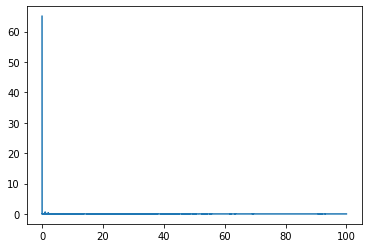

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700002.edf
700002 Total: 193 samples | data length: 35432 (array([2, 3, 4]), array([ 22, 170,   1]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700002.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7201999  =      0.000 ... 36009.995 secs...
['Nasal', 'Thermistor', 'EKG', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 7202000)
720200

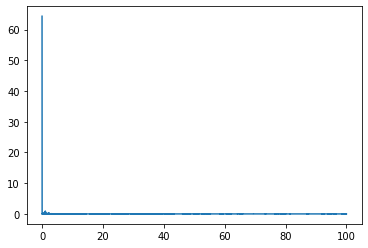

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700003.edf
700003 Total: 166 samples | data length: 29663 (array([2, 3]), array([  5, 161]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700003.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9571999  =      0.000 ... 47859.995 secs...


<ipython-input-7-d461e0bb5afe>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'EKG', 'Thermistor', 'Thorax', 'Nasal', 'Flow', 'Abdomen'}. Applying running numbers for duplicates.
  f = mne.io.read_raw_edf(fname, preload=True)


['Nasal-0', 'Nasal-1', 'Thermistor-0', 'Thermistor-1', 'EKG-0', 'Thorax-0', 'Thorax-1', 'Abdomen-0', 'Abdomen-1', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow-0', 'Flow-1', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow', 'EKG-1']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 9572000)
9572000


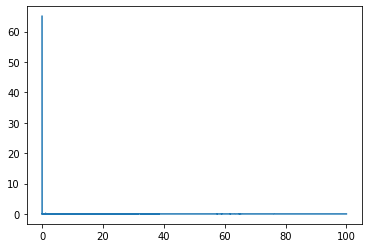

  0%|          | 0/1596 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700004.edf
700004 Total: 171 samples | data length: 29041 (array([1, 2, 3]), array([  3,  21, 147]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700004.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17281999  =      0.000 ... 86409.995 secs...
['Nasal', 'Thermistor', 'EKG', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 17282000)
1728

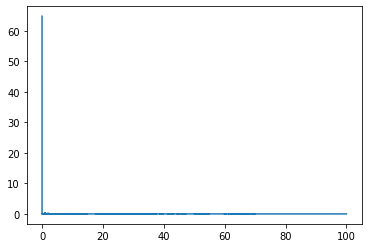

  0%|          | 0/2881 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700005.edf
700005 Total: 127 samples | data length: 26376 (array([2, 3]), array([ 10, 117]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700005.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8281999  =      0.000 ... 41409.995 secs...
['Nasal', 'Thermistor', 'EKG', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 8282000)
8282000


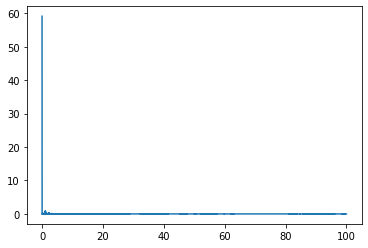

  0%|          | 0/1381 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700006.edf
700006 Total: 142 samples | data length: 33902 (array([2, 3]), array([  9, 133]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700006.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8641999  =      0.000 ... 43209.995 secs...
['Nasal', 'Thermistor', 'EKG', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 8642000)
8642000


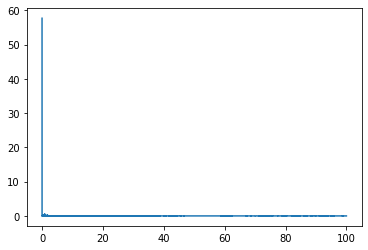

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700007.edf
700007 Total: 240 samples | data length: 37757 (array([2, 3, 4]), array([  7, 232,   1]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700007.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8641999  =      0.000 ... 43209.995 secs...


<ipython-input-7-d461e0bb5afe>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'Thermistor', 'Thorax', 'Nasal', 'Flow', 'Abdomen'}. Applying running numbers for duplicates.
  f = mne.io.read_raw_edf(fname, preload=True)


['Nasal-0', 'Nasal-1', 'Thermistor-0', 'Thermistor-1', 'EKG', 'Thorax-0', 'Thorax-1', 'Abdomen-0', 'Abdomen-1', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow-0', 'Flow-1', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 8642000)
8642000


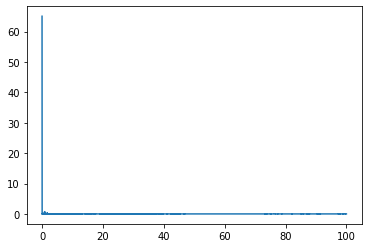

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700008.edf
700008 Total: 145 samples | data length: 35615 (array([2, 3]), array([  1, 144]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700008.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8641999  =      0.000 ... 43209.995 secs...


In [ ]:
################################### Multi-Label

output_path = '../nas/NSRR/processed/processed_dataset/heartbeat/multilabel/60_stride_30/'
create_file_windows_MTM(windows_size = 60, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = 'processed_dataset/numom2b/multilabel/60/'
# create_file_windows_MTM(windows_size = 60, stride = 60, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

# ################################### SPO2
# output_path = 'processed_dataset/numom2b/90/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 90, stride = 90, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

# output_path = 'processed_dataset/numom2b/90_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 90, stride = 90, shifted = 20, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

# output_path = '../nas/NSRR/processed/processed_dataset/heartbeat/60/'
# create_file_windows(windows_size = 60, stride = 60, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

# output_path = 'processed_dataset/numom2b/60_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 60, stride = 60, shifted = 20, threshold = 0.5 , output_path = output_path,signal_type =  SIGNAL_READ_SPO2)

# output_path = 'processed_dataset/numom2b/30/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 30, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

# output_path = 'processed_dataset/numom2b/30_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 30, stride = 30, shifted = 20, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_SPO2)

################################### PPG
# output_path = 'processed_dataset/numom2b/90/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 90, stride = 90, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = 'processed_dataset/numom2b/90_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 90, stride = 90, shifted = 20, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = '../nas/NSRR/processed/processed_dataset/heartbeat/60/'
# create_file_windows(windows_size = 60, stride = 60, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = 'processed_dataset/numom2b/60_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 60, stride = 60, shifted = 20, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = 'processed_dataset/numom2b/30/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 30, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)

# output_path = 'processed_dataset/numom2b/30_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows(windows_size = 30, stride = 30, shifted = 20, threshold = 0.5 , output_path = output_path, signal_type = SIGNAL_READ_PPG)




../nas/NSRR/HeartBEAT/heartbeat/polysomnography/annotations-events-nsrr/baseline/heartbeat-baseline-700075.edf
700075 Total: 376 samples | data length: 43176 (array([2, 3, 4]), array([  5, 370,   1]))
../nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700075.edf
Extracting EDF parameters from /mount/nas/NSRR/HeartBEAT/heartbeat/polysomnography/edfs/baseline/heartbeat-baseline-700075.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8641999  =      0.000 ... 43209.995 secs...


<ipython-input-18-d461e0bb5afe>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'Thorax', 'Nasal', 'Thermistor', 'Abdomen', 'Flow'}. Applying running numbers for duplicates.
  f = mne.io.read_raw_edf(fname, preload=True)


['Nasal-0', 'Nasal-1', 'Thermistor-0', 'Thermistor-1', 'EKG', 'Thorax-0', 'Thorax-1', 'Abdomen-0', 'Abdomen-1', 'Gravity X', 'Gravity Y', 'Battery', 'Snore', 'Differential Pre', '0-1v DC', 'SpO2', 'SpO2-BB', 'Pulse', 'RD-Pleth', 'SpO2-Quality', 'RD-Quality', 'Flow-0', 'Flow-1', 'Activity', 'Elevation', 'Position', 'Phase', 'RMI', 'RR', 'XSum', 'Tidal Volume', 'XFlow']
🚨 No resampling applied (sampling rate is 200.0 Hz. as original).
(1, 8642000)
8642000


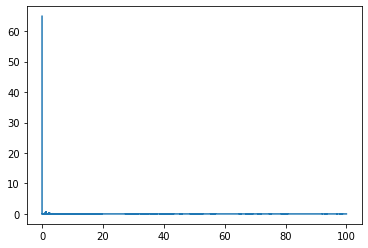

RAW_FS : 200


  0%|          | 0/721 [00:00<?, ?it/s]

Found last window


In [24]:
windows_size = 60
shifted = 0
stride = 60
# fname = 'chat-baseline-' + '300026' + '.edf'
fname = 'heartbeat-baseline-700075.edf'

pid = fname[-len('.edf')-6:-len('.edf')]
check_path = 'ppg'
if check_path == SIGNAL_READ_SPO2:
    check_kw = 'chat_spo2_'
elif check_path == SIGNAL_READ_PPG:
    check_kw = 'chat_ppg_'

print(pjoin(ANNOTATION_PATH, fname))

anno_file = pjoin(ANNOTATION_PATH, 'heartbeat-baseline-' + pid + '-nsrr.xml')
all_labels, pid = extract_labels(anno_file)

raw_signals, raw_fs = read_signals(pjoin(RAW_EDF_PATH, fname), 'RD-Pleth')


raw_fs = int(raw_fs)
print('RAW_FS :', raw_fs)
labels = []
signal_data = []
overlap_count = 0
for idx, curr_seconds in tqdm(enumerate(range(0, len(raw_signals)//raw_fs, stride)), total = len(raw_signals)//raw_fs//stride+1):
    start_window = curr_seconds
    end_window = curr_seconds + windows_size
    window_labels = []    
    for sec in range(curr_seconds, curr_seconds + windows_size):
        is_normal, is_c_apnea, is_o_apnea, is_hypopnea, flag_curr = True, False, False, False, False
        for i, data in enumerate(all_labels):
            start = data['start'] - shifted                
            duration = data['duration']
            stop = start + duration
            if sec < stop and sec >= start:        
                if flag_curr == True:
                    overlap_count += 1
                is_normal = False
                if(data['event'] in [4, 5]): #Unsure
                    label = 0
                 #High priority first
                if(data['event'] == 1): #Central Apnea
                    is_c_apnea = True
                elif(data['event'] == 2): #Obstructive Apnea
                    is_o_apnea = True
                elif(data['event'] == 3): #Hypopnea
                    is_hypopnea = True
                flag_curr = True

        if is_normal:
            label = 0    
        #High priority first if overlap   
        if(is_c_apnea == True):
            label = 1
        elif(is_o_apnea == True):
            label = 2  
        elif(is_hypopnea == True):
            label = 3

        window_labels.append(label)

    #GET SIGNALS
    cut_data = raw_signals[start_window * raw_fs: end_window * raw_fs]
    if(cut_data.shape[0] != windows_size*raw_fs):
        print('Found last window')
        continue
    signal_data.append(cut_data)
    labels.append(window_labels)


In [13]:
# plt.plot(signal_data[100])
count = 0
for l in labels:
    if any(d != 0 for d in l):
        count += 1
        print(count, l)

NameError: name 'labels' is not defined

In [ ]:
plt.plot(signal_data[400][:])

In [ ]:
labels = np.array(labels)

In [ ]:
labels.shape